In [ ]:
d = dists.Binomial(256, 0.5)
support = jnp.array(d.enumerate_support())*2 - 256
probabilities = jnp.exp(d.log_prob(d.enumerate_support()))

phase = jnp.linspace(-256, 256, 1000)
scale = jnp.logspace(-1, 2, 1000)

for bins in [2**5, 2**6]:
    MIs = MI(scale, phase, bins, support, probabilities)
    max_idx = MIs.argmax()
    max_scale_idx, max_phase_idx = jnp.unravel_index(max_idx, MIs.shape)
    max_scale = scale[max_scale_idx]
    max_phase = phase[max_phase_idx]

    plt.plot(scale, MIs, label=f'{bins} bins')

$$\begin{align}
\text{MI}(Y;N) &= \sum_{n} p_N(n) \sum_{y} p_{Y|N}(y|n,\theta) \left( \log p_{Y|N}(y|n, \theta) - \log p_Y(y | \theta) \right) \\
\frac{d}{d\theta_i}\text{MI}(Y;N) &= \sum_{n} p_N(n) \sum_{y} \left[\left(\frac{d}{d\theta_i}p_{Y|N}(y|n,\theta)\right) \left( \log p_{Y|N}(y|n, \theta) - \log p_Y(y | \theta) \right) + p_{Y|N}(y|n,\theta) \left(\frac{\frac{d}{d\theta_i}p_{Y|N}(y|n, \theta)}{p_{Y|N}(y|n, \theta)} - \frac{\sum_k p_N(k) \frac{d}{d\theta_i} p_{Y|N}(y | k, \theta)}{p_Y(y | \theta)} \right) \right] \\
\frac{d}{d\theta_i} p_{Y|N}(y | k, \theta) &= \frac{d}{d\theta_i} \left( \Phi(\frac{\theta_{y+1}-k}{\sigma}) - \Phi(\frac{\theta_{y}-k}{\sigma})\right) = \frac{1}{\sigma}\phi(\frac{\theta_{i}-k}{\sigma}) \begin{cases} 1 & \text{ if } i = y+1 \\ -1 & \text{ if } i = y \\ 0 & \text{ otherwise} \end{cases} \\
\end{align}$$

$$\begin{align}
\frac{d}{d\theta_i}\text{MI}(Y;N) &= \sum_{n} p_N(n) [\frac{1}{\sigma}\phi(\frac{\theta_i-n}{\sigma})\left( \log p_{Y|N}(i-1|n, \theta) - \log p_Y(i-1 | \theta) - \log p_{Y|N}(i | n, \theta) + \log p_Y(i | \theta) \right) \\
&\quad - p_{Y|N}(i-1 | n, \theta)\frac{\sum_k p_N(k) \frac{1}{\sigma}\phi(\frac{\theta_i-k}{\sigma}) }{p_Y(i-1 | \theta)} + p_{Y|N}(i | n, \theta)\frac{\sum_k p_N(k) \frac{1}{\sigma}\phi(\frac{\theta_i-k}{\sigma}) }{p_Y(i | \theta)}]
\end{align}$$

In [ ]:
d1 = dists.Binomial(256, 0.25)
d2 = dists.Binomial(256, 0.75)
support = d1.enumerate_support()
logp1 = d1.log_prob(support)
logp2 = d2.log_prob(support)
support = ((support - support.mean())*2).astype(int)
d = EmpiricalDistribution(support, 0.5*jnp.exp(logp1)+0.5*jnp.exp(logp2))

Num bits: 5
Num thresholds: 32


33

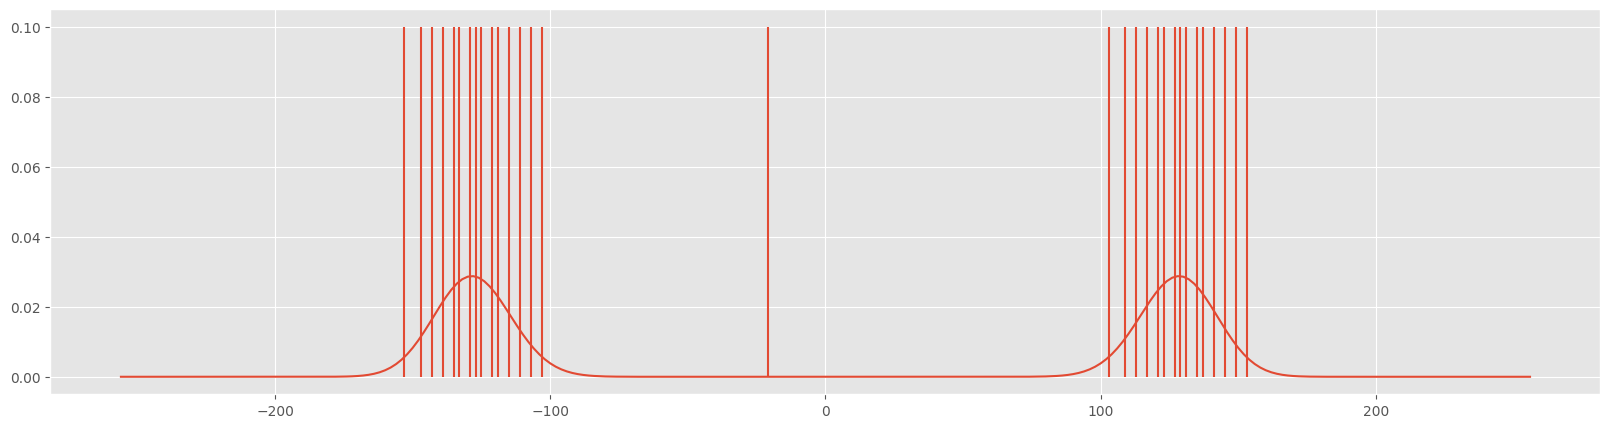

In [ ]:
thresholds = place_thresholds(d, 5)

plt.figure(figsize=(20, 5))
plt.vlines(thresholds, 0.0, 0.1)
plt.plot(d.support, d.probs)
len(thresholds)

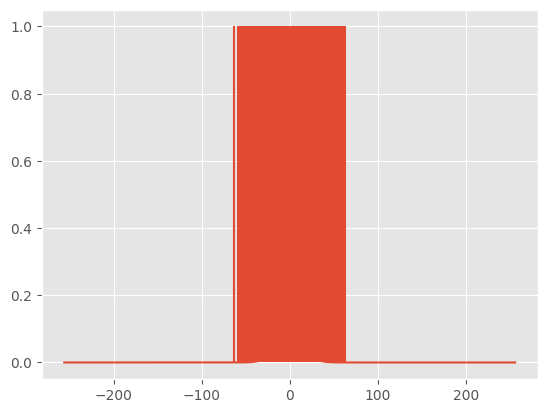

In [ ]:
plt.plot(d.support, jnp.exp(d.log_prob(d.support)))
plt.vlines(theta, 0, 1)
# plt.xlim(-50,50)

In [ ]:
class StepFunction(object):
    thresholds: jnp.ndarray
    values: jnp.ndarray

    def __init__(self, thresholds, values=None):
        if values is None:
            values = jnp.arange(len(thresholds)-1)
        assert len(thresholds) == len(values)+1, "Thresholds must be one longer than values"
        self.thresholds = thresholds.at[0].set(-jnp.inf).at[-1].set(jnp.inf)
        self.values = values

    def __call__(self, x):
        idx = jnp.searchsorted(self.thresholds, x)-1
        return self.values[idx]
    from matplotlib.ticker import MaxNLocator, MultipleLocator

def plot_quantization(
    ax_fun,
    thresholds,
    dist=None,
    color=None,
    linecolor=None,
    xticklocator=MultipleLocator(64),
    yticklocator=MaxNLocator(integer=True),
    remove_endpoints=True,
    xmin=None,
    xmax=None,
    step=True,
    twinaxis=True,
):
    if linecolor is None:
        linecolor = color

    if remove_endpoints:
        thresholds = thresholds[1:-1]

    if xmin is None:
        if dist is not None:
            xmin = dist.support.min()
        else:
            xmin = thresholds.min()
    if xmax is None:
        if dist is not None:
            xmax = dist.support.max()
        else:
            xmax = thresholds.max()

    num_levels = len(thresholds) + 1

    xx = jnp.linspace(xmin, xmax, 1001)

    if dist is not None:
        nn = dist.support
        n_cdf = dist.cdf(nn)

        if twinaxis:
            # callback for when the ylim of ax_cdf is changed
            def update_cdf_ylim(ax_fun):
                y1, y2 = ax_fun.get_ylim()
                ax_cdf.set_ylim(y1 / (num_levels - 1), y2 / (num_levels - 1))
                ax_cdf.figure.canvas.draw()

            # create twin axis for the CDF
            ax_cdf = ax_fun.twinx()
            # swap zorder so that the CDF is behind the quantization levels
            ax_fun.set_zorder(ax_cdf.get_zorder() + 1)

            # automatically update ylim of ax2 when ylim of ax1 changes.
            ax_fun.callbacks.connect("ylim_changed", update_cdf_ylim)

            ax_cdf.yaxis.label.set_color("gray")
            ax_cdf.tick_params(axis="y", colors="gray")
            ax_cdf.grid(True, zorder=0)
            ax_cdf.xaxis.grid(True, zorder=0)
            ax_fun.grid(False)
            ax_cdf.set_ylabel("cumulative prob.")
            # Set ax's patch invisible
            ax_fun.patch.set_visible(False)
            # Set axtwin's patch visible and colorize it in grey
            ax_cdf.patch.set_visible(True)
            ax_cdf.patch.set_facecolor(ax_fun.patch.get_facecolor())
            scale = 1
        else:
            ax_cdf = ax_fun
            scale = num_levels - 1

        if step:
            l1 = ax_cdf.step(nn, n_cdf * scale, color="gray", where="post", label="CDF")
        else:
            nn_mid = (nn[1:] + nn[:-1]) / 2
            n_cdf_mid = (n_cdf[1:] + n_cdf[:-1]) / 2
            l1 = ax_cdf.plot(nn_mid, n_cdf_mid * scale, color="gray", label="CDF")
    else:
        l1 = []

    l2 = ax_fun.step(
        xx,
        jnp.searchsorted(thresholds, xx),
        color=linecolor,
        linewidth=1,
        label="$Q(\\tilde y)$",
    )

    if color is not None:
        ax_fun.yaxis.label.set_color(color)
        ax_fun.tick_params(axis="y", colors=color)
    ax_fun.set_ylabel("level")

    ax_fun.xaxis.set_major_locator(xticklocator)
    ax_fun.yaxis.set_major_locator(yticklocator)
    ax_fun.set_xlim(xmin - (xmax - xmin) * 0.05, xmax + (xmax - xmin) * 0.05)

    if twinaxis:
        return ax_cdf, ax_fun, l1 + l2
    else:
        return ax_fun, l1 + l2

Array([ -inf, -255., -253., -251., -249., -247., -245., -243., -241.,
       -239., -237., -235., -233., -231., -229., -227., -225., -223.,
       -221., -219., -217., -215., -213., -211., -209., -207., -205.,
       -203., -201., -199., -197., -195., -193., -191., -189., -187.,
       -185., -183., -181., -179., -177., -175., -173., -171., -169.,
       -167., -165., -163., -161., -159., -157., -155., -153., -151.,
       -149., -147., -145., -143., -141., -139., -137., -135., -133.,
       -131., -129., -127., -125., -123., -121., -119., -117., -115.,
       -113., -111., -109., -107., -105., -103., -101.,  -99.,  -97.,
        -95.,  -93.,  -91.,  -89.,  -87.,  -85.,  -83.,  -81.,  -79.,
        -77.,  -75.,  -73.,  -71.,  -69.,  -67.,  -65.,  -63.,  -61.,
        -59.,  -57.,  -55.,  -53.,  -51.,  -49.,  -47.,  -45.,  -43.,
        -41.,  -39.,  -37.,  -35.,  -33.,  -31.,  -29.,  -27.,  -25.,
        -23.,  -21.,  -19.,  -17.,  -15.,  -13.,  -11.,   -9.,   -7.,
         -5.,   -3.,

In [ ]:
from dataclasses import dataclass
import heapq

from tqdm import tqdm

def place_thresholds(dbase: EmpiricalDistribution, num_bits, transform=None):
    @dataclass
    class SubDistribution:
        d: EmpiricalDistribution

        @property
        def priority(self):
            if transform is None:
                h = self.d.entropy()
            else:
                h = self.d.transform(lambda x: jnp.searchsorted(transform, x)-1).entropy()
            return jax.scipy.special.logsumexp(dbase.log_prob(self.d.support))+jnp.log(h)

        def __lt__(self, other: "SubDistribution"):
            return self.priority > other.priority

    heap = [SubDistribution(dbase)]

    print(f"Num bits: {num_bits}")

    retired = []

    i = 0
    while i < (2**num_bits)-1:
        # take highest entropy chunk
        head = heapq.heappop(heap)
        dd = head.d

        if len(dd.support) == 1:
            retired.append(head)
            print(f"Warning: singleton chunk found with priority {head.priority}")
            # break
            continue

        i+=1

        # find the split position (should always slide off at least one value)
        if dd.probs[0] > 0.5:
            pos = (dd.support[0]+dd.support[-1])/2
        else:
            pos = dd.icdf(0.5)
            
        # split it into two halves
        _,d1,_,d2 = dd.split(pos)
        child1 = SubDistribution(d1)
        child2 = SubDistribution(d2)

        # add the two halves back to the heap
        heapq.heappush(heap, child1)
        heapq.heappush(heap, child2)

    heap.extend(retired)

    print(f"Num thresholds: {len(heap)}")
    
    thresholds_min = []
    thresholds_max = []
    for v in heap:
        thresholds_min.append(v.d.support[0])
        thresholds_max.append(v.d.support[-1])
    thresholds_min = jnp.array(sorted(thresholds_min))
    thresholds_max = jnp.array(sorted(thresholds_max))
    thresholds = (thresholds_max[:-1] + thresholds_min[1:])/2
    thresholds = jnp.concatenate([jnp.array([-jnp.inf]), thresholds, jnp.array([jnp.inf])])
    return thresholds

Num bits: 4
Num thresholds: 16
Num bits: 4, num thresholds: 17


100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


[ -inf -225. -193. -161. -129.  -97.  -65.  -33.   -1.   31.   63.   95.
  127.  159.  191.  223.   inf]
Num bits: 4, num thresholds: 17
Num bits: 4, num thresholds: 17


Text(13.041999999999996, 0.5, '$p_Y(y|\\theta)$')

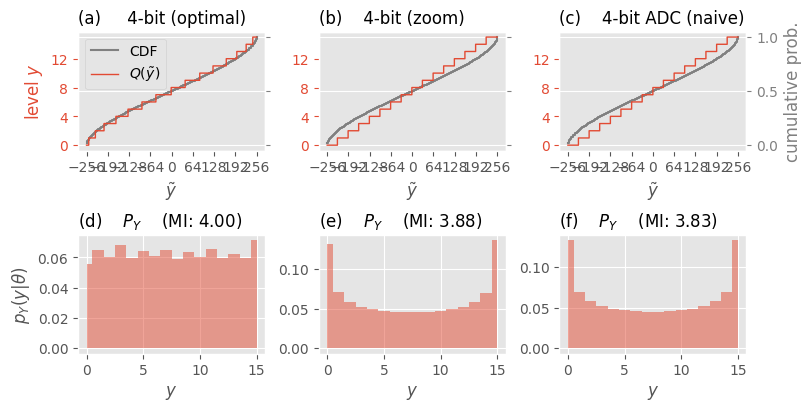

In [ ]:

# create the figure
from matplotlib.ticker import MultipleLocator


fig, ax = plt.subplots(2, 3, figsize=(8, 4), layout="constrained")
# share_axis(ax[:,:-1], sharex="row", sharey="row")

vector_length = 256
self = dists.Binomial(vector_length, 0.5)
support = jnp.array(self.enumerate_support())*2 - vector_length
probabilities = jnp.exp(self.log_prob(self.enumerate_support()))

phase = jnp.linspace(-vector_length, vector_length, 1000)
scale = jnp.logspace(-1, 2, 1000)
noise_std=0.1

vmin, vmax = 0, jnp.log2(4*jnp.pi*jnp.e)
all_thresholds = []

cases = [("(a)     4-bit (optimal)", "(d)    $P_Y$", 4, "optimal"),("(b)    4-bit (zoom)", "(e)    $P_Y$", 4, "zoom"),("(c)    4-bit ADC (naive)", "(f)    $P_Y$", 4, "uniform")]
for i,(label1, label2, bits, method) in enumerate(cases):
    # compute MI for different scales and phases
    mi, thresholds = find_optimal(bits, d, noise_std=noise_std, method=method, transform=transform, scale_search_range=(0.1, 20))
    all_thresholds.append(thresholds)
    print(f"Num bits: {bits}, num thresholds: {len(thresholds)}")

    ax_cdf, ax_fun, lines = plot_quantization(ax[0,i], thresholds, dist=d, color=f"C0", yticklocator=MultipleLocator(2**(bits-2)))
    # ax_sweep, im = plot_sweep(ax[1,i], phase, scale, MIs, annotate=(max_phase, max_scale, max_MI), vmin=vmin, vmax=vmax, cmap="viridis", rasterized=True)
    
    if i != 0:
        ax_fun.yaxis.label.set_visible(False)

    if i == 2:
        ax_cdf.yaxis.label.set_visible(True)
        ax_cdf.set_yticks([0,0.5,1.0])
    else:
        ax_cdf.yaxis.label.set_visible(False)
        plt.setp(ax_cdf.get_yticklabels(), visible=False)

    # im = plot_sweep()

    labels = [l.get_label() for l in lines]

    ax_fun.set_ylabel("level $y$")
    ax_fun.set_xlabel("$\\tilde{y}$")
    # ax_fun.set_xlim(-80,80)
    ax_fun.set_title(label1, fontsize=12, loc="left")
    # ax_sweep.set_title(label2, fontsize=12, loc="left")
    # ax_sweep.set_xlabel("offset")
    if i == 0:
        ax_fun.legend(handles=lines, labels=labels, loc="upper left", fancybox=True, ncol=1)

    

    yy = jnp.arange(len(thresholds)-1)
    P_y = jnp.exp(log_pdf_y(d, yy, thresholds[jnp.newaxis,:], noise_std=noise_std))
    ax[1,i].fill_between(yy, P_y, step="mid", alpha=0.5)

    ax[1,i].set_title(label2 + f"    (MI: {mi:.2f})", fontsize=12, loc="left")
    ax[1,i].set_xlabel("$y$")

# fig.colorbar(im, ax=ax[1,:], label="MI (bits)", pad=-0.075)
# place legend in axis, hide everything else
# ax[0,-1].axis("off")

ax[1, 0].set_ylabel("$p_Y(y|\\theta)$")

# fig.savefig("../figures/optimum.pdf", bbox_inches="tight")
# fig.savefig("../figures/optimum.svg", bbox_inches="tight")
# fig.savefig("../figures/optimum.png", bbox_inches="tight", dpi=300)

In [ ]:
num_bits = 6
transform = jnp.arange(-3, 2**num_bits+3, 2.0).at[0].set(-jnp.inf).at[-1].set(jnp.inf)

In [ ]:
for thresholds in all_thresholds:
    m = []
    s = []
    tc = []
    dtemp = EmpiricalDistribution(d.support, log_probs=d.log_probs)
    for i, t in enumerate(thresholds[1:]):
        _, d1, _, d2 = dtemp.split(t)
        dtemp = d2
        if transform is not None:
            d1_trans = d1.transform(lambda x: jnp.searchsorted(transform, x)-1)
        else:
            d1_trans = d1
        if len(d1.support) == 0:
            continue
        m.append(d1_trans.mean)
        s.append(d1_trans.std)
        m.append(d1_trans.mean)
        s.append(d1_trans.std)
        tc.append(d1.support.min())
        tc.append(d1.support.max())
    m=jnp.array(m)
    s=jnp.array(s)
    tc=jnp.array(tc)

    
    plt.fill_between(tc, m+s, m-s, alpha=0.5)
    plt.plot(tc, m, "-o")
# plt.xlim(-10,100)
# plt.ylim(-10,40)